## Импорт библиотек

In [172]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

%matplotlib inline

## Загрузка данных

In [2]:
# !unzip World_Airports_Data.zip

In [3]:
data = pd.read_csv("airports.csv")

In [4]:
data.head()

,id,ident,type,name,latitude_deg,longitude_deg,elevation_ft,continent,iso_country,iso_region,municipality,scheduled_service,gps_code,iata_code,local_code,home_link,wikipedia_link,keywords
0,6523,00A,heliport,Total Rf Heliport,40.070801,-74.933601,11.0,NaN,US,US-PA,Bensalem,no,00A,NaN,00A,NaN,NaN,NaN
1,323361,00AA,small_airport,Aero B Ranch Airport,38.704022,-101.473911,3435.0,NaN,US,US-KS,Leoti,no,00AA,NaN,00AA,NaN,NaN,NaN
2,6524,00AK,small_airport,Lowell Field,59.947733,-151.692524,450.0,NaN,US,US-AK,Anchor Point,no,00AK,NaN,00AK,NaN,NaN,NaN
3,6525,00AL,small_airport,Epps Airpark,34.864799,-86.770302,820.0,NaN,US,US-AL,Harvest,no,00AL,NaN,00AL,NaN,NaN,NaN
4,506791,00AN,small_airport,Katmai Lodge Airport,59.093287,-156.456699,80.0,NaN,US,US-AK,King Salmon,no,00AN,NaN,00AN,NaN,NaN,NaN


In [5]:
data.shape

(75606, 18)

Данные взяты отсюда: https://www.kaggle.com/datasets/danishjmeo/world-airports-data  
Открытый набор данных из ''Open data @ourAirports'' об аэропортах мира и прогнозах о задержках рейсов и маршрутах движения.  
Официальная страница датасета: https://ourairports.com/help/data-dictionary.html  
Там же находится подробное описание всех колонок.  
Краткое описание колонок:
- **id** - id
- **ident** - идентификационный номер. Название зависит от наличия ICAO и местного кода
- **type** - тип
- **name** - название
- **latitude_deg** - широта в десятичных градусах
- **longitude_deg** - долгота в десятичных градусах
- **elevation_ft** - высота над уровнем моря в футах
- **continent** - континент (аббревиатура)
- **iso_country** - страна (аббревиатура)
- **iso_region** - регион
- **municipality** - город
- **scheduled_service** - осуществляется регулярное авиасообщение
- **gps_code** - код GPS
- **iata_code** - Трёхбуквенный код iata
- **local_code** - местный код
- **home_link** - сайт
- **wikipedia_link** - страница на википедии
- **keywords** - ключевые слова

Для удобства создадим отдельный DataFrame с описанием колонок

In [6]:
column_descriptions = ["id", "идентификационный номер. То же самое, что и id, но в изменённом формате", "тип",
                       "название", "широта в градусах", "долгота в градусах", "высота над уровнем моря",
                       "континент (аббревиатура)", "страна (аббревиатура)", "регион", "город",
                       "регулярные рейсы по расписанию", "код GPS", "код iata", "локальный код", "сайт",
                       "страница на википедии", "ключевые слова"]

In [7]:
data.columns

Index(['id', 'ident', 'type', 'name', 'latitude_deg', 'longitude_deg',
       'elevation_ft', 'continent', 'iso_country', 'iso_region',
       'municipality', 'scheduled_service', 'gps_code', 'iata_code',
       'local_code', 'home_link', 'wikipedia_link', 'keywords'],
      dtype='object')

In [8]:
pd.DataFrame(columns=["Описание"], index = data.columns, data=column_descriptions)

,Описание
id,id
ident,"идентификационный номер. То же самое, что и id..."
type,тип
name,название
latitude_deg,широта в градусах
longitude_deg,долгота в градусах
elevation_ft,высота над уровнем моря
continent,континент (аббревиатура)
iso_country,страна (аббревиатура)
iso_region,регион


## Предварительная обработка данных

In [9]:
data[data["continent"] == "NA"]

,id,ident,type,name,latitude_deg,longitude_deg,elevation_ft,continent,iso_country,iso_region,municipality,scheduled_service,gps_code,iata_code,local_code,home_link,wikipedia_link,keywords


Похоже, Pandas неправильно обработал название континента Северной Америки. Проверяю, так ли это

In [10]:
data.continent.unique()

array([nan, 'OC', 'AF', 'AN', 'EU', 'AS', 'SA'], dtype=object)

In [11]:
data.groupby("continent")["iso_country"].nunique()

continent
AF    59
AN     3
AS    57
EU    53
OC    26
SA    14
Name: iso_country, dtype: int64

In [12]:
data["continent"].value_counts()

AS    11010
SA    10306
EU     9781
AF     3971
OC     3889
AN       43
Name: continent, dtype: int64

In [13]:
data["continent"].isna().sum()

36606

In [14]:
data[data["continent"].isna() == True]["iso_country"].unique()

array(['US', 'PR', 'CO', 'AG', 'AI', 'MX', 'AW', 'GL', 'GB', 'BM', 'BQ',
       'BS', 'BZ', 'CA', 'CR', 'CU', 'PA', 'DO', 'GT', 'GP', 'HN', 'HT',
       'JM', 'KN', 'KY', 'PM', 'TC', 'GD', 'NI', 'MQ', 'SV', 'MF', 'VI',
       'VE', 'BB', 'DM', 'BL', 'LC', 'CW', 'SX', 'VG', 'MS', 'TT', 'VC'],
      dtype=object)

Обрабатывать вручную все страны слишком долго, поэтому с помощью ChatGPT проверю принадлежность стран к континентам 

US - Соединенные Штаты Америки (NA - North America)  
PR - Пуэрто-Рико (NA - North America)  
CO - Колумбия (SA - South America)  
AG - Антигуа и Барбуда (NA - North America)  
AI - Ангилья (NA - North America)  
MX - Мексика (NA - North America)  
AW - Аруба (SA - South America)  
GL - Гренландия (NA - North America)  
GB - Великобритания (EU - Europe)  
BM - Бермудские острова (NA - North America)  
BQ - Бонайре, Синт-Эстатиус и Саба (SA - South America)  
CA - Канада (NA - North America)  
BS - Багамы (NA - North America)  
BZ - Белиз (NA - North America)  
CR - Коста-Рика (NA - North America)  
CU - Куба (NA - North America)  
PA - Панама (NA - North America)  
DO - Доминиканская Республика (NA - North America)  
GT - Гватемала (NA - North America)  
GP - Гваделупа (NA - North America)  
HN - Гондурас (NA - North America)  
HT - Гаити (NA - North America)  
JM - Ямайка (NA - North America)  
KN - Сент-Китс и Невис (NA - North America)  
KY - Каймановы острова (NA - North America)  
PM - Сен-Пьер и Микелон (NA - North America)  
TC - Теркс и Кайкос (NA - North America)  
GD - Гренада (NA - North America)  
NI - Никарагуа (NA - North America)  
MQ - Мартиника (NA - North America)  
SV - Сальвадор (NA - North America)  
MF - Сен-Мартен (NA - North America)  
VI - Виргинские острова США (NA - North America)  
VE - Венесуэла (SA - South America)  
BB - Барбадос (NA - North America)  
DM - Доминика (NA - North America)  
BL - Сен-Бартелеми (NA - North America)  
LC - Сент-Люсия (NA - North America)  
CW - Кюрасао (SA - South America)  
SX - Синт-Мартен (NA - North America)  
VG - Британские Виргинские острова (NA - North America)

In [15]:
country_continent = {
    'US': 'NA',
    'PR': 'NA',
    'CO': 'SA',
    'AG': 'NA',
    'AI': 'NA',
    'MX': 'NA',
    'AW': 'SA',
    'GL': 'NA',
    'GB': 'EU',
    'BM': 'NA',
    'BQ': 'SA',
    'CA': 'NA',
    'BS': 'NA',
    'BZ': 'NA',
    'CR': 'NA',
    'CU': 'NA',
    'PA': 'NA',
    'DO': 'NA',
    'GT': 'NA',
    'GP': 'NA',
    'HN': 'NA',
    'HT': 'NA',
    'JM': 'NA',
    'KN': 'NA',
    'KY': 'NA',
    'PM': 'NA',
    'TC': 'NA',
    'GD': 'NA',
    'NI': 'NA',
    'MQ': 'NA',
    'SV': 'NA',
    'MF': 'NA',
    'VI': 'NA',
    'VE': 'SA',
    'BB': 'NA',
    'DM': 'NA',
    'BL': 'NA',
    'LC': 'NA',
    'CW': 'SA',
    'SX': 'NA',
    'VG': 'NA'
}

In [16]:
data.head()

,id,ident,type,name,latitude_deg,longitude_deg,elevation_ft,continent,iso_country,iso_region,municipality,scheduled_service,gps_code,iata_code,local_code,home_link,wikipedia_link,keywords
0,6523,00A,heliport,Total Rf Heliport,40.070801,-74.933601,11.0,NaN,US,US-PA,Bensalem,no,00A,NaN,00A,NaN,NaN,NaN
1,323361,00AA,small_airport,Aero B Ranch Airport,38.704022,-101.473911,3435.0,NaN,US,US-KS,Leoti,no,00AA,NaN,00AA,NaN,NaN,NaN
2,6524,00AK,small_airport,Lowell Field,59.947733,-151.692524,450.0,NaN,US,US-AK,Anchor Point,no,00AK,NaN,00AK,NaN,NaN,NaN
3,6525,00AL,small_airport,Epps Airpark,34.864799,-86.770302,820.0,NaN,US,US-AL,Harvest,no,00AL,NaN,00AL,NaN,NaN,NaN
4,506791,00AN,small_airport,Katmai Lodge Airport,59.093287,-156.456699,80.0,NaN,US,US-AK,King Salmon,no,00AN,NaN,00AN,NaN,NaN,NaN


In [17]:
data["continent"] = data['continent'].fillna(data['iso_country'].map(country_continent))

In [18]:
data.continent

0        NA
1        NA
2        NA
3        NA
4        NA
         ..
75601    EU
75602    AF
75603    NA
75604    NA
75605    AS
Name: continent, Length: 75606, dtype: object

In [19]:
data.continent.isnull().sum()

11

In [20]:
data[data["continent"].isna() == True]["iso_country"].unique()

array(['MS', 'TT', 'VC'], dtype=object)

Похоже, ChatGPT сопоставил материки не всем странам.
Ничего страшного, дополнительным запросом был получен обновлённый словарь

In [21]:
country_continent = {
    'US': 'NA',
    'PR': 'NA',
    'CO': 'SA',
    'AG': 'NA',
    'AI': 'NA',
    'MX': 'NA',
    'AW': 'SA',
    'GL': 'NA',
    'GB': 'EU',
    'BM': 'NA',
    'BQ': 'SA',
    'CA': 'NA',
    'BS': 'NA',
    'BZ': 'NA',
    'CR': 'NA',
    'CU': 'NA',
    'PA': 'NA',
    'DO': 'NA',
    'GT': 'NA',
    'GP': 'NA',
    'HN': 'NA',
    'HT': 'NA',
    'JM': 'NA',
    'KN': 'NA',
    'KY': 'NA',
    'PM': 'NA',
    'TC': 'NA',
    'GD': 'NA',
    'NI': 'NA',
    'MQ': 'NA',
    'SV': 'NA',
    'MF': 'NA',
    'VI': 'NA',
    'VE': 'SA',
    'BB': 'NA',
    'DM': 'NA',
    'BL': 'NA',
    'LC': 'NA',
    'CW': 'SA',
    'SX': 'NA',
    'VG': 'NA',
    'MS': 'NA',
    'TT': 'NA',
    'VC': 'NA'
}

In [22]:
data["continent"] = data['continent'].fillna(data['iso_country'].map(country_continent))

In [23]:
data.continent.isnull().sum()

0

Отлично, я избавился от отсутствующих значений в одном из столбцов

In [24]:
data.head()

,id,ident,type,name,latitude_deg,longitude_deg,elevation_ft,continent,iso_country,iso_region,municipality,scheduled_service,gps_code,iata_code,local_code,home_link,wikipedia_link,keywords
0,6523,00A,heliport,Total Rf Heliport,40.070801,-74.933601,11.0,NA,US,US-PA,Bensalem,no,00A,NaN,00A,NaN,NaN,NaN
1,323361,00AA,small_airport,Aero B Ranch Airport,38.704022,-101.473911,3435.0,NA,US,US-KS,Leoti,no,00AA,NaN,00AA,NaN,NaN,NaN
2,6524,00AK,small_airport,Lowell Field,59.947733,-151.692524,450.0,NA,US,US-AK,Anchor Point,no,00AK,NaN,00AK,NaN,NaN,NaN
3,6525,00AL,small_airport,Epps Airpark,34.864799,-86.770302,820.0,NA,US,US-AL,Harvest,no,00AL,NaN,00AL,NaN,NaN,NaN
4,506791,00AN,small_airport,Katmai Lodge Airport,59.093287,-156.456699,80.0,NA,US,US-AK,King Salmon,no,00AN,NaN,00AN,NaN,NaN,NaN


In [25]:
data.isnull().sum()

id                       0
ident                    0
type                     0
name                     0
latitude_deg             0
longitude_deg            0
elevation_ft         14253
continent                0
iso_country            259
iso_region               0
municipality          4969
scheduled_service        0
gps_code             34388
iata_code            66734
local_code           42997
home_link            71989
wikipedia_link       64666
keywords             58836
dtype: int64

In [26]:
data.iloc[:, 6:].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75606 entries, 0 to 75605
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   elevation_ft       61353 non-null  float64
 1   continent          75606 non-null  object 
 2   iso_country        75347 non-null  object 
 3   iso_region         75606 non-null  object 
 4   municipality       70637 non-null  object 
 5   scheduled_service  75606 non-null  object 
 6   gps_code           41218 non-null  object 
 7   iata_code          8872 non-null   object 
 8   local_code         32609 non-null  object 
 9   home_link          3617 non-null   object 
 10  wikipedia_link     10940 non-null  object 
 11  keywords           16770 non-null  object 
dtypes: float64(1), object(11)
memory usage: 6.9+ MB


Считаю процент ненулевых данных по столбцам:

In [27]:
{k: "%.3f" %(v / data.shape[0]) for k, v in data.notnull().sum().to_dict().items() if v < 75605}

{'elevation_ft': '0.811',
 'iso_country': '0.997',
 'municipality': '0.934',
 'gps_code': '0.545',
 'iata_code': '0.117',
 'local_code': '0.431',
 'home_link': '0.048',
 'wikipedia_link': '0.145',
 'keywords': '0.222'}

In [28]:
useless_columns = ["gps_code", "iata_code", "local_code", "home_link", "wikipedia_link", "keywords"]

In [29]:
data = data.drop(useless_columns, axis=1)

In [30]:
data.isnull().sum()

id                       0
ident                    0
type                     0
name                     0
latitude_deg             0
longitude_deg            0
elevation_ft         14253
continent                0
iso_country            259
iso_region               0
municipality          4969
scheduled_service        0
dtype: int64

In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75606 entries, 0 to 75605
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 75606 non-null  int64  
 1   ident              75606 non-null  object 
 2   type               75606 non-null  object 
 3   name               75606 non-null  object 
 4   latitude_deg       75606 non-null  float64
 5   longitude_deg      75606 non-null  float64
 6   elevation_ft       61353 non-null  float64
 7   continent          75606 non-null  object 
 8   iso_country        75347 non-null  object 
 9   iso_region         75606 non-null  object 
 10  municipality       70637 non-null  object 
 11  scheduled_service  75606 non-null  object 
dtypes: float64(3), int64(1), object(8)
memory usage: 6.9+ MB


Так нулевых значений стало заметно меньше

Оставшиеся пропуски можно заполнить средним значением в случае количественной переменной elevation_ft и модой в остальных случаях

In [32]:
data["elevation_ft"] = data["elevation_ft"].fillna(data["elevation_ft"].mean())

In [33]:
data["iso_country"] = data["iso_country"].fillna(data["iso_country"].mode()[0])

In [34]:
data["municipality"] = data["municipality"].fillna(data["municipality"].mode()[0])

In [35]:
data.isnull().sum()

id                   0
ident                0
type                 0
name                 0
latitude_deg         0
longitude_deg        0
elevation_ft         0
continent            0
iso_country          0
iso_region           0
municipality         0
scheduled_service    0
dtype: int64

Таким образом, я лишился недостающих значений

Также было решено избавиться от признака "id". Из второго идентификационного признака "ident" можно извлечь хотя бы какую-то информацию, так как он содержит определённые паттерны, когда "id" полностью состоит из цифр без закономерностей. К тому же, в структуре таблицы Pandas уже есть числовая идентификация

In [36]:
data = data.drop("id", axis=1)

Также потребуется изменить значения признака "scheduled_service" с "yes" и "no" на 0 и 1 

In [37]:
data["scheduled_service"] = data["scheduled_service"].replace({"no": 0, "yes": 1})

In [38]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75606 entries, 0 to 75605
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ident              75606 non-null  object 
 1   type               75606 non-null  object 
 2   name               75606 non-null  object 
 3   latitude_deg       75606 non-null  float64
 4   longitude_deg      75606 non-null  float64
 5   elevation_ft       75606 non-null  float64
 6   continent          75606 non-null  object 
 7   iso_country        75606 non-null  object 
 8   iso_region         75606 non-null  object 
 9   municipality       75606 non-null  object 
 10  scheduled_service  75606 non-null  int64  
dtypes: float64(3), int64(1), object(7)
memory usage: 6.3+ MB


In [39]:
data.nunique()

ident                75606
type                     7
name                 71561
latitude_deg         74379
longitude_deg        74650
elevation_ft          6211
continent                7
iso_country            244
iso_region            2883
municipality         33963
scheduled_service        2
dtype: int64

In [40]:
data.head()

,ident,type,name,latitude_deg,longitude_deg,elevation_ft,continent,iso_country,iso_region,municipality,scheduled_service
0,00A,heliport,Total Rf Heliport,40.070801,-74.933601,11.0,NA,US,US-PA,Bensalem,0
1,00AA,small_airport,Aero B Ranch Airport,38.704022,-101.473911,3435.0,NA,US,US-KS,Leoti,0
2,00AK,small_airport,Lowell Field,59.947733,-151.692524,450.0,NA,US,US-AK,Anchor Point,0
3,00AL,small_airport,Epps Airpark,34.864799,-86.770302,820.0,NA,US,US-AL,Harvest,0
4,00AN,small_airport,Katmai Lodge Airport,59.093287,-156.456699,80.0,NA,US,US-AK,King Salmon,0


Получилось следующее:  
Качественные признаки: ident, name, municipality  
Категориальные признаки: type, continent, iso_country, iso_region, scheduled_service  
Количественные признаки: latitude_deg, longitude_deg, elevation_ft  

One Hot Encoding для преобразования категориальных признаков в числовые лучше сделать после анализа для удобства восприятия

## Статистический анализ данных

По количественным данным выведем распространённые статистические характеристики

In [41]:
data[["latitude_deg", "longitude_deg", "elevation_ft"]].describe()

,latitude_deg,longitude_deg,elevation_ft
count,75606.000000,75606.000000,75606.000000
mean,25.668021,-28.716193,1303.355516
std,26.243138,86.298564,1507.670952
min,-90.000000,-179.876999,-1266.000000
25%,11.920085,-94.126930,310.000000
50%,35.120061,-69.713506,1001.000000
75%,42.660076,24.363960,1303.355516
max,82.750000,179.975700,17372.000000


По текстовым признакам показатели несколько другие

In [42]:
data.describe(include="object")

,ident,type,name,continent,iso_country,iso_region,municipality
count,75606,75606,75606,75606,75606,75606,75606
unique,75606,7,71561,7,244,2883,33963
top,00A,small_airport,Centre Hospitalier Heliport,NA,US,US-TX,Osaka
freq,1,39549,83,36548,30503,3649,5388


По классифицирующим признакам выведу гистограммы

[]

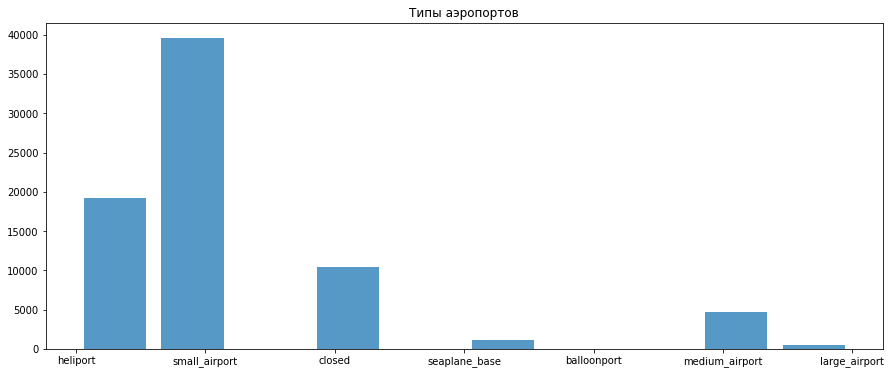

In [43]:
fig = plt.figure(figsize=(15, 6))
plt.hist(data.type, rwidth=0.8, alpha=0.75)
plt.title("Типы аэропортов")
plt.plot()

[]

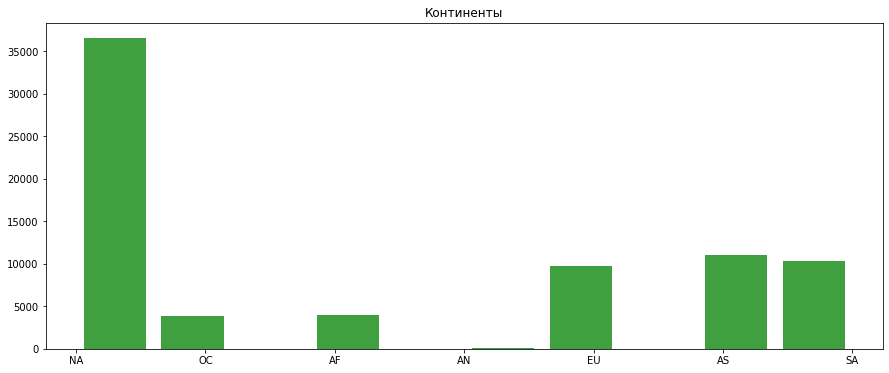

In [44]:
fig = plt.figure(figsize=(15, 6))
plt.hist(data.continent, rwidth=0.8, color="green", alpha=0.75)
plt.title("Континенты")
plt.plot()

[]

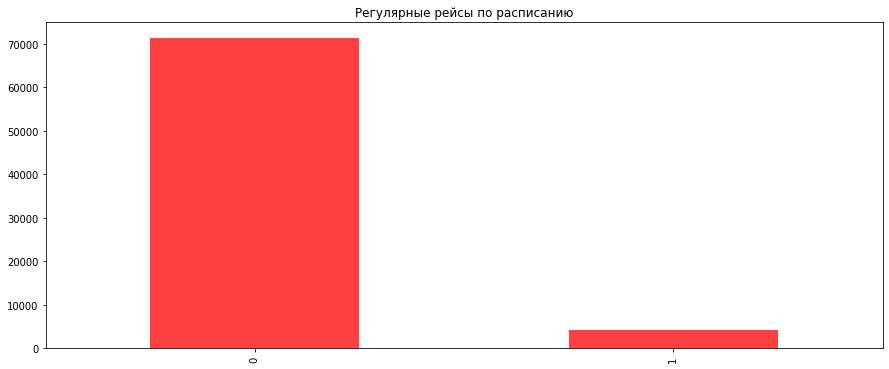

In [45]:
fig = plt.figure(figsize=(15, 6))
data.scheduled_service.value_counts().plot.bar(color="red", alpha=0.75)
plt.title("Регулярные рейсы по расписанию")
plt.plot()

По признакам iso_country и iso_region выведу топ-10 популярных значений, так как в них слишком много уникальных записей

In [46]:
data[["iso_country"]].value_counts().to_frame().head(10)

,0
iso_country,
US,30503
BR,6704
JP,3407
CA,3033
AU,2557
MX,2261
RU,1545
KR,1400
GB,1374


In [47]:
data[["iso_region"]].value_counts().to_frame().head(10)

,0
iso_region,
US-TX,3649
US-CA,2321
US-FL,1220
BR-SP,1208
GB-ENG,1123
US-IL,1067
US-AK,1043
BR-MT,1037
US-PA,1010


По широте и долготе можно посмотреть преобладающие области расположения аэропортов

[]

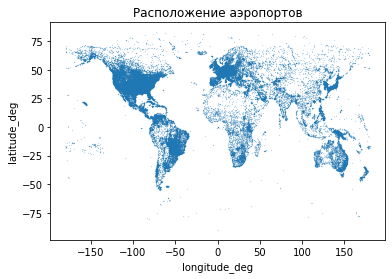

In [48]:
data.plot.scatter(x="longitude_deg", y="latitude_deg", s=0.01)
plt.title("Расположение аэропортов")
plt.plot()

Получилась карта мира, и можно сделать вывод, что преобладающая часть аэропортов находится в Северной и Южной Америках, а также в Европе

Но гораздо удобнее это сделать в приложении Google Earth Pro. В силу того, что данные изменились, лучше использовать изначальный набор данных

In [49]:
data.head()

,ident,type,name,latitude_deg,longitude_deg,elevation_ft,continent,iso_country,iso_region,municipality,scheduled_service
0,00A,heliport,Total Rf Heliport,40.070801,-74.933601,11.0,NA,US,US-PA,Bensalem,0
1,00AA,small_airport,Aero B Ranch Airport,38.704022,-101.473911,3435.0,NA,US,US-KS,Leoti,0
2,00AK,small_airport,Lowell Field,59.947733,-151.692524,450.0,NA,US,US-AK,Anchor Point,0
3,00AL,small_airport,Epps Airpark,34.864799,-86.770302,820.0,NA,US,US-AL,Harvest,0
4,00AN,small_airport,Katmai Lodge Airport,59.093287,-156.456699,80.0,NA,US,US-AK,King Salmon,0


## Гипотезы

**Проверим несколько гипотез:**

1) Наличие регулярных рейсов по расписанию должно зависеть от типа аэропорта. Скорее всего, у больших аэропортов вероятность выше

In [50]:
data.groupby('type').mean()["scheduled_service"].to_frame().sort_values(by="scheduled_service", ascending=False)

,scheduled_service
type,
large_airport,0.982759
medium_airport,0.587085
seaplane_base,0.031386
small_airport,0.021391
heliport,0.005253
closed,0.001824
balloonport,0.000000


Действительно, у больших и средних аэропортов вероятность наличия регулярных рейсов сильно выше, чем у остальных

Отображу типы аэропортов на графике:

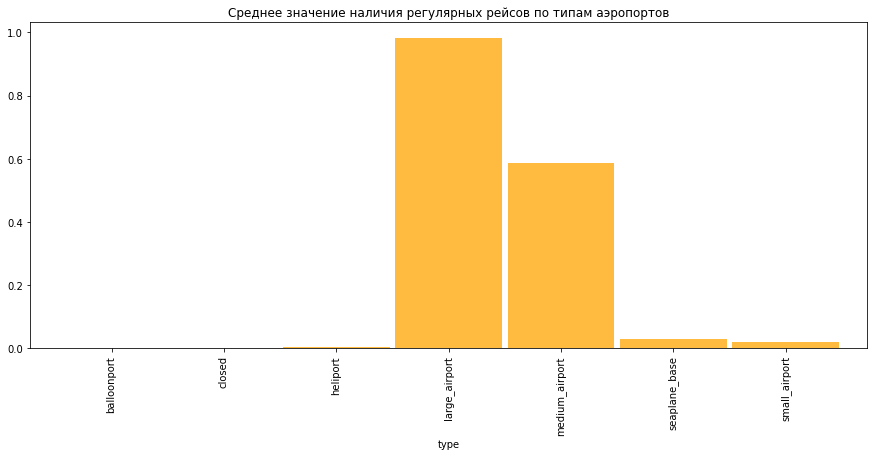

In [51]:
fig = plt.figure(figsize=(15, 6))
data.groupby('type').mean()["scheduled_service"].plot.bar(width=0.95, color="orange", alpha=0.75)
plt.title("Среднее значение наличия регулярных рейсов по типам аэропортов")
plt.show()

2) Возможно, географическое расположение (в десятичных градусах по широте и долготе) также влияет на наличие регулярных рейсов.

In [52]:
data[["latitude_deg", "longitude_deg", "scheduled_service"]].corr()

,latitude_deg,longitude_deg,scheduled_service
latitude_deg,1.000000,-0.238167,-0.019870
longitude_deg,-0.238167,1.000000,0.121825
scheduled_service,-0.019870,0.121825,1.000000


Рассчитаю корреляцию между широтой, долготой и наличием регулярных рейсов

[]

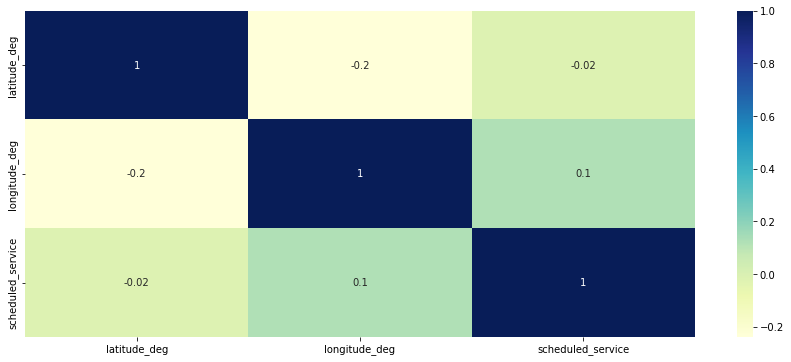

In [53]:
fig = plt.figure(figsize=(15, 6))
sns.heatmap(data[["latitude_deg", "longitude_deg", "scheduled_service"]].corr(), annot=True, fmt='.1g', cmap="YlGnBu")
plt.plot()

Как видно из графика, на наличие регулярного авиасообщения больше всего влияет долгота аэропорта. Но зависимость не сильно большая

3) Должна быть зависимость между широтой и долготой местоположения аэропортов. Данная информация может рассказать о географических особенностях расположения аэропортов, а также о том, в каких областях расположено больше всего аэропортов с наличием регулярных рейсов

In [54]:
data[["latitude_deg", "longitude_deg"]].corr()

,latitude_deg,longitude_deg
latitude_deg,1.000000,-0.238167
longitude_deg,-0.238167,1.000000


Нужно посмотреть на разброс значений данных признаков

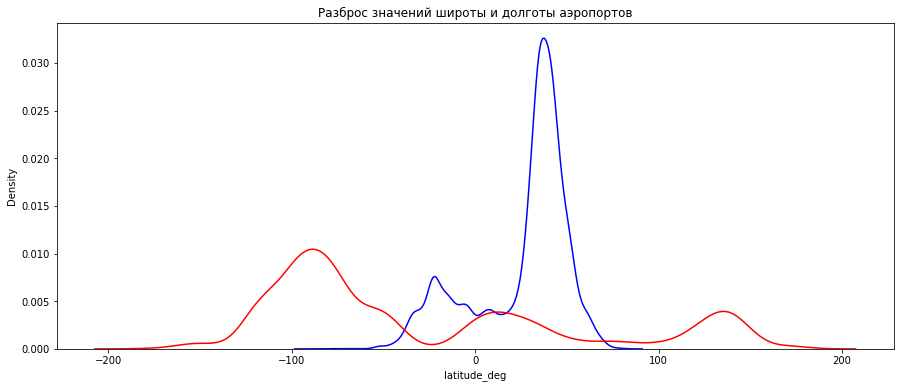

In [55]:
fig = plt.figure(figsize=(15, 6))
sns.kdeplot(data['latitude_deg'], color="b")
sns.kdeplot(data['longitude_deg'], color="r")
plt.title("Разброс значений широты и долготы аэропортов")
plt.show()

Как было показано ранее, можно выделить определённые области на карте по координатам, в которых у аэропортов больше вероятность иметь регулярные рейсы

[]

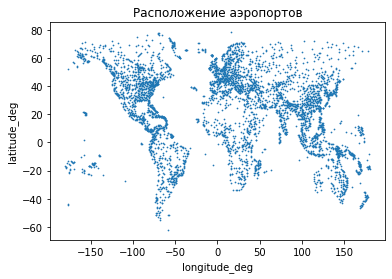

In [56]:
data[data["scheduled_service"] == 1].plot.scatter(x="longitude_deg", y="latitude_deg", s=0.5)
plt.title("Расположение аэропортов")
plt.plot()

Размер точек был изменён для большей наглядности.  Можно заметить несколько крупных областей с преобладанием аэропортов, у которых есть регулярные рейсы

4) На основании зависимости широты и долготы, а также зависимости наличия регулярных рейсов от типа аэропорта, можно предположить гипотезу о зависимости типа аэропорта от его географического положения

In [57]:
data.groupby('type').mean()[["latitude_deg", "longitude_deg"]]

,latitude_deg,longitude_deg
type,,
balloonport,35.383294,-42.773620
closed,35.031782,-54.439127
heliport,28.438109,-7.869993
large_airport,27.482761,11.589782
medium_airport,26.799939,4.203048
seaplane_base,44.058645,-83.513378
small_airport,21.152467,-34.898489


Выведу сначала график зависимости:

<Figure size 1080x432 with 0 Axes>

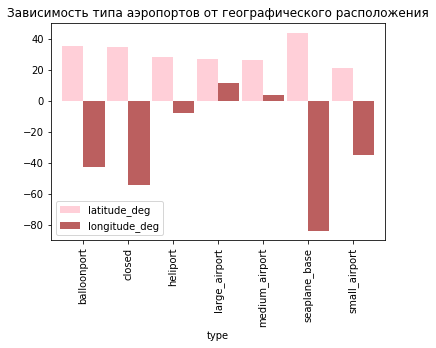

In [58]:
fig = plt.figure(figsize=(15, 6))
data.groupby('type').mean()[["latitude_deg", "longitude_deg"]].plot.bar(width=0.95, color=("pink", "brown"), alpha=0.75)
plt.title("Зависимость типа аэропортов от географического расположения")
plt.show()

И графики координат по типам аэропортов: 

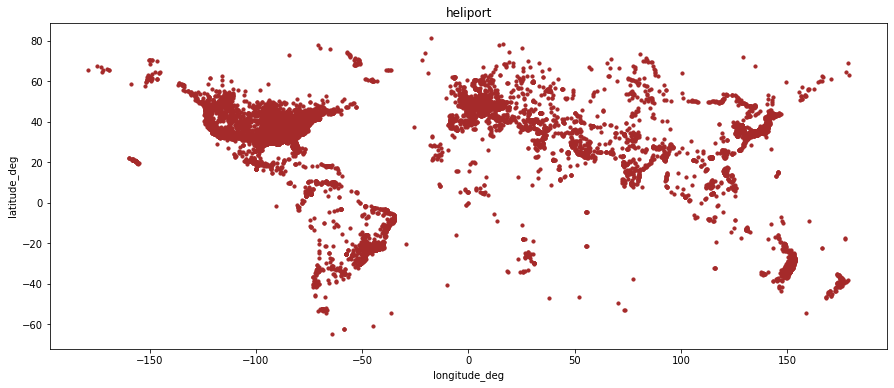

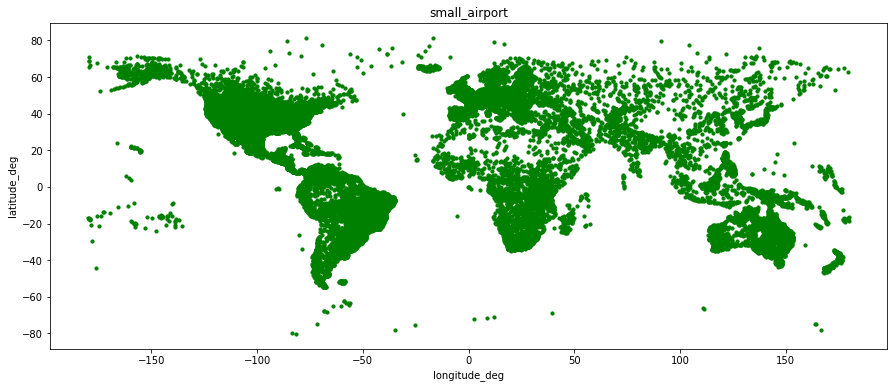

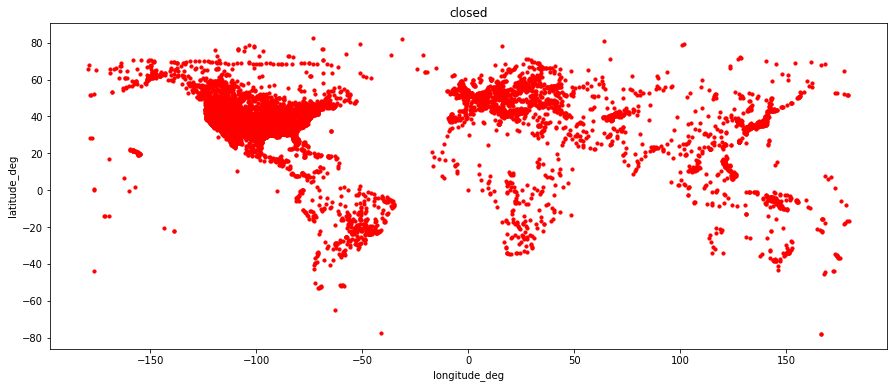

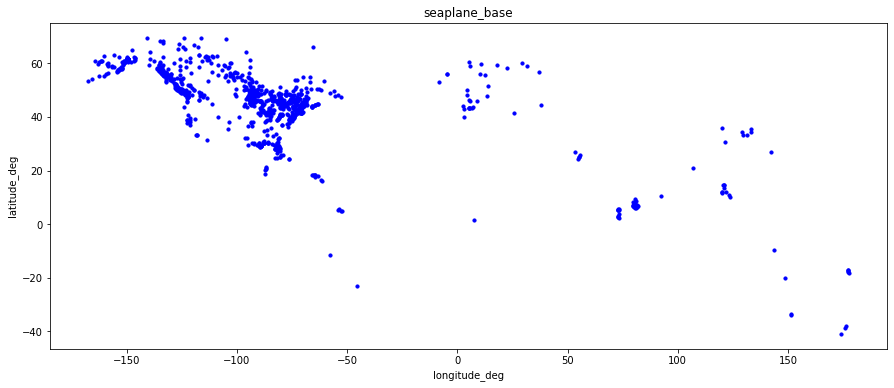

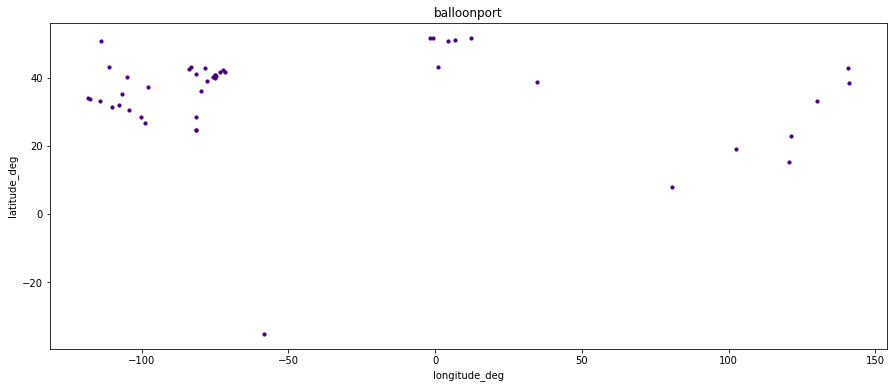

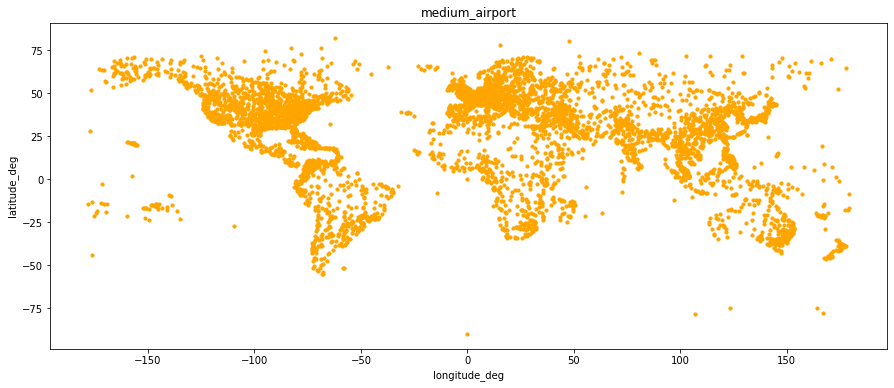

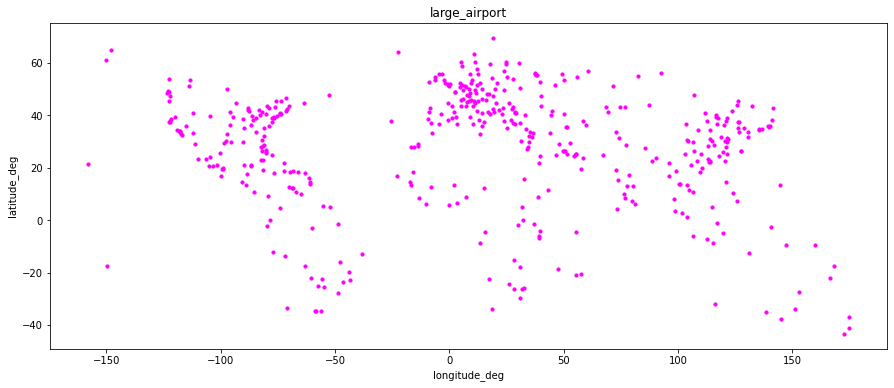

In [59]:
colors= iter(["brown", "green", "red", "blue", "indigo", "orange", "fuchsia"])
for t in data["type"].unique().tolist():
    fig = plt.figure(figsize=(15, 6))
    plt.scatter(data=data[data["type"] == t], x="longitude_deg", y="latitude_deg", color=next(colors), s=10)
    plt.title(t)
    plt.xlabel("longitude_deg")
    plt.ylabel("latitude_deg")
    plt.show()

На картах можно увидеть, где каких типов аэропортов больше всего

Не помешает вывести гистограмму распределения типов аэропортов:

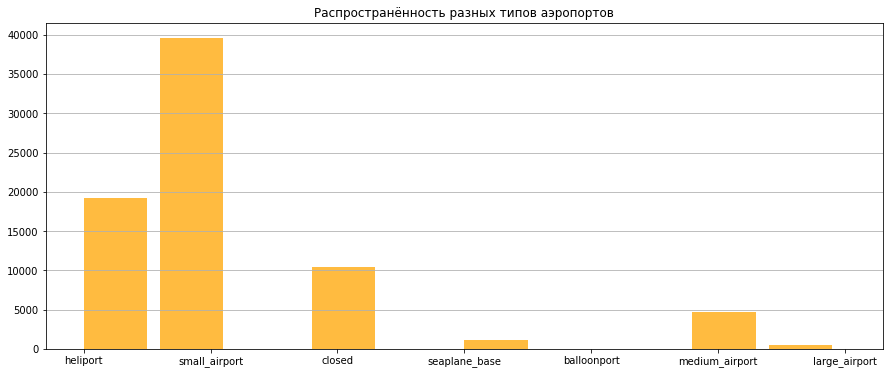

In [60]:
fig = plt.figure(figsize=(15, 6))
data["type"].hist(width=0.5, color="orange", alpha=0.75)
plt.title("Распространённость разных типов аэропортов")
plt.grid(False, axis="x")
plt.show()

Выходит, больше всего распространены маленькие аэропорты; меньше средние, закрытые и вертолётные площадки; больших аэропортов и баз гидросамолётов заметно меньше; а площадок запуска воздушных шаров практически нет

5) Ещё можно предположить, что наличие регулярных рейсов зависит от материка, страны и региона.

Выделю новые наборы данных:

In [61]:
data.groupby('continent').mean()["scheduled_service"].sort_values(ascending=False).to_frame()

,scheduled_service
continent,
AS,0.114260
AF,0.110803
OC,0.109283
EU,0.068595
SA,0.037730
NA,0.029085
AN,0.023256


In [62]:
data.groupby('iso_country').mean()["scheduled_service"].sort_values(ascending=False).to_frame()

,scheduled_service
iso_country,
JE,1.0
DM,1.0
CC,1.0
BL,1.0
WF,1.0
...,...
LI,0.0
IO,0.0
HM,0.0


In [63]:
data.groupby('iso_region').mean()["scheduled_service"].sort_values(ascending=False).to_frame()

,scheduled_service
iso_region,
TH-64,1.0
MN-071,1.0
MN-047,1.0
MN-059,1.0
SC-14,1.0
...,...
LR-NI,0.0
LR-MY,0.0
LR-LO,0.0


Сначала выведу диаграмму зависимости данного признака от материка, на котором расположен аэропорт:

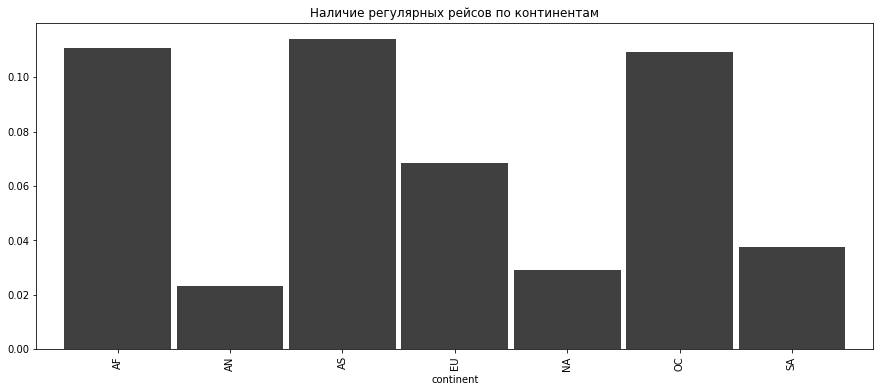

In [64]:
fig = plt.figure(figsize=(15, 6))
data.groupby('continent').mean()["scheduled_service"].plot.bar(width=0.95, color="black", alpha=0.75)
plt.title("Наличие регулярных рейсов по континентам")
plt.show()

Заметно выделяются Африка, Азия, Австралия и Океания; за ними Европа. Стоит заметить, что в использованных данных Австралия и Океания относятся к признаку "Материки", хотя на самом деле являются частью Света.

<Figure size 432x288 with 0 Axes>

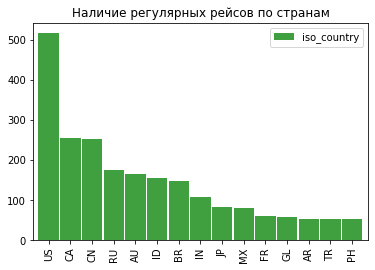

<Figure size 432x288 with 0 Axes>

In [65]:
data[data.scheduled_service == True].iso_country.value_counts().to_frame().head(15).plot.bar(width=0.95, color="green", alpha=0.75)
plt.title("Наличие регулярных рейсов по странам")
plt.figure()

На первом месте США, после идут Канада, Китай и другие

И в подобном виде отображу регионы:

<Figure size 432x288 with 0 Axes>

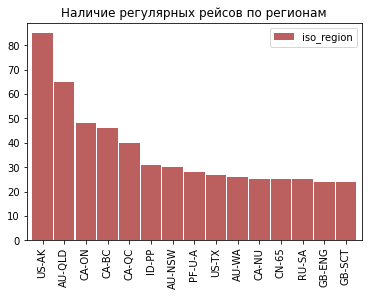

<Figure size 432x288 with 0 Axes>

In [66]:
data[data.scheduled_service == True].iso_region.value_counts().to_frame().head(15).plot.bar(width=0.95, color="brown", alpha=0.75)
plt.title("Наличие регулярных рейсов по регионам")
plt.figure()

Преобладают штаты Аляска США и Квинсленд Австралии

6) Ранее я оставил столбец ident для выделения новых признаков. Попробую добавить к набору данных столбец длины ident и посмотреть корреляцию с наличием регулярных рейсов

In [67]:
len_ident_list = [len(id) for id in data.ident]

In [68]:
data.insert(loc=len(data.columns), column='len_ident', value=len_ident_list)

In [69]:
data.head()

,ident,type,name,latitude_deg,longitude_deg,elevation_ft,continent,iso_country,iso_region,municipality,scheduled_service,len_ident
0,00A,heliport,Total Rf Heliport,40.070801,-74.933601,11.0,NA,US,US-PA,Bensalem,0,3
1,00AA,small_airport,Aero B Ranch Airport,38.704022,-101.473911,3435.0,NA,US,US-KS,Leoti,0,4
2,00AK,small_airport,Lowell Field,59.947733,-151.692524,450.0,NA,US,US-AK,Anchor Point,0,4
3,00AL,small_airport,Epps Airpark,34.864799,-86.770302,820.0,NA,US,US-AL,Harvest,0,4
4,00AN,small_airport,Katmai Lodge Airport,59.093287,-156.456699,80.0,NA,US,US-AK,King Salmon,0,4


[]

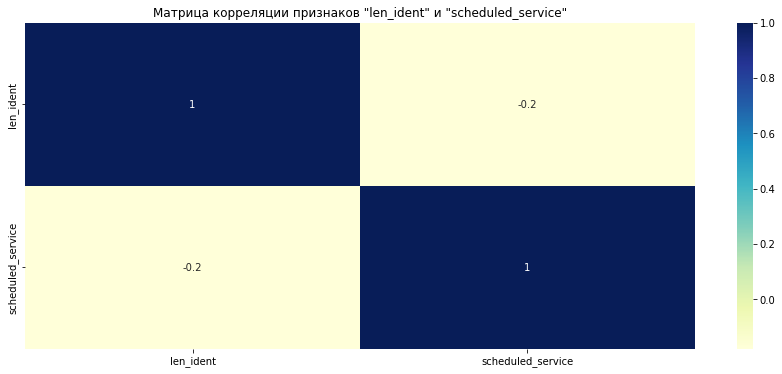

In [70]:
fig = plt.figure(figsize=(15, 6))
sns.heatmap(data[["len_ident", "scheduled_service"]].corr(), annot=True, fmt='.1g', cmap="YlGnBu")
plt.title('Матрица корреляции признаков "len_ident" и "scheduled_service"')
plt.plot()

Как видно на тепловой карте, существует некоторая зависимость, сравнимая с корреляцией между долготой и наличием регулярных рейсов. Новый признак можно оставить

## Машинное обучение

In [71]:
data.head()

,ident,type,name,latitude_deg,longitude_deg,elevation_ft,continent,iso_country,iso_region,municipality,scheduled_service,len_ident
0,00A,heliport,Total Rf Heliport,40.070801,-74.933601,11.0,NA,US,US-PA,Bensalem,0,3
1,00AA,small_airport,Aero B Ranch Airport,38.704022,-101.473911,3435.0,NA,US,US-KS,Leoti,0,4
2,00AK,small_airport,Lowell Field,59.947733,-151.692524,450.0,NA,US,US-AK,Anchor Point,0,4
3,00AL,small_airport,Epps Airpark,34.864799,-86.770302,820.0,NA,US,US-AL,Harvest,0,4
4,00AN,small_airport,Katmai Lodge Airport,59.093287,-156.456699,80.0,NA,US,US-AK,King Salmon,0,4


Путём тестов было выявлено, что набор данных слишком большой для используемого компьютера. К тому же, в нём содержатся числа с плавающей точкой высокой точности. Необходимо уменьшить объём всех записей и избавиться от характеристики "municipality".

In [85]:
data.shape

(75606, 12)

Это я сделаю прямо в ходе разделения данных на 2 части с функцией train_test_split

Для начала нужно разделить датасет на тренировочные и тестовые данные. С помощью тренировочных данных будет проводиться обучение моделей, а с помощью тестовых - тестироваться их точность

In [120]:
train_data, test_data = train_test_split(data, train_size=0.4, random_state=1)

train_data.reset_index(inplace=True)
test_data.reset_index(inplace=True)

In [121]:
test_data, extra_data = train_test_split(test_data, train_size=0.2, random_state=1)

In [122]:
train_data.shape

(30242, 13)

In [123]:
test_data.shape

(9072, 13)

Такой объём подойдёт

In [124]:
y_train = train_data.scheduled_service
y_test = test_data.scheduled_service

DictVectorizer:

In [125]:
useful_features = ['type', 'continent', 'iso_country', 'iso_region',
                   'latitude_deg', 'longitude_deg', 'elevation_ft', 'len_ident']

train_dicts = train_data[useful_features].to_dict(orient='records')
test_dicts = test_data[useful_features].to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)
X_test = dv.transform(test_dicts)

In [129]:
X_train.shape

(30242, 2462)

In [130]:
X_test.shape

(9072, 2462)

Произведу нормирование данных для ускорения обучения

In [157]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Попробую обучить 3 разных алгоритма: логистическую регрессию, случайный лес и XGBoost.

In [295]:
model = LogisticRegression(max_iter=100)
model.fit(X_train, y_train)

c:\Users\grigo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

Напишу специальную функцию для отображения метрик:

In [245]:
def print_metrics(input_model):
    y_train_prediction = input_model.predict(X_train)
    y_test_prediction = input_model.predict(X_test)

    print('Train MSE: %.3f' % mean_squared_error(y_train, y_train_prediction))
    print('Test MSE: %.3f' % mean_squared_error(y_test, y_test_prediction))

    print('Train MAE: %.3f' % mean_absolute_error(y_train, y_train_prediction))
    print('Test MAE: %.3f' % mean_absolute_error(y_test, y_test_prediction))

    CM = confusion_matrix(y_test, y_test_prediction)

    ax= plt.subplot()
    sns.heatmap(CM, annot=True, fmt="g", cmap="YlGnBu")
    ax.set_xlabel('Предсказанные значения')
    ax.set_ylabel('Действительные значения')
    ax.set_title('Матрица ошибок')
    ax.xaxis.set_ticklabels(['False', 'True'])
    ax.yaxis.set_ticklabels(['False', 'True'])

    plt.plot()

    TN = CM[0][0]
    FN = CM[1][0]
    TP = CM[1][1]
    FP = CM[0][1]

    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    
    print("accuracy: %.2f" % (accuracy))
    print("precision: %.2f" % (precision))
    print("recall: %.2f" % (recall))

    print("roc_auc_score: %.2f" % roc_auc_score(y_train, y_train_prediction))

MSE - среднеквадратичное значение ошибки.  
MAE - абсолютное (то есть, ризница между действительным и предсказанным значением) значение ошибки.  
Метрика accuracy отвечает за общий процент правильных ответов.  
Precison показывает точность определения положительных ответов.  
Recall отвечает за то, насколько полно модель охватывает положительные ответы.  
Roc_auc_score показывает процент площади правильных ответов, а именно то, насколько модель точно различает 2 класса. При настройке гиперпараметров я буду использовать именно эту метрику.

Train MSE: 0.039
Test MSE: 0.037
Train MAE: 0.039
Test MAE: 0.037
accuracy: 0.96
precision: 0.65
recall: 0.63
roc_auc_score: 0.81


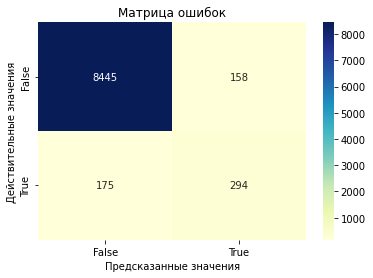

In [296]:
print_metrics(model)

Даже с учётом относительно небольшого объёма данных и модели с маленьким количеством итераций результат впечатляет

Попробую обучить RandomForestClassifier:

In [297]:
model = RandomForestClassifier(n_estimators=10, random_state=1)
model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10, random_state=1)

Train MSE: 0.004
Test MSE: 0.033
Train MAE: 0.004
Test MAE: 0.033
accuracy: 0.97
precision: 0.71
recall: 0.61
roc_auc_score: 0.97


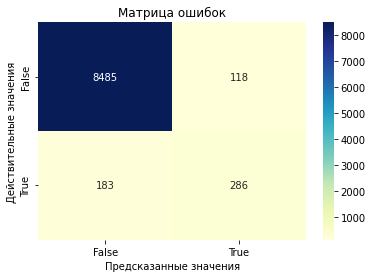

In [298]:
print_metrics(model)

Результат значительно лучше

Теперь обучу XGBoost:

In [247]:
model = xgboost.XGBClassifier(n_estimators=100, random_state=1)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=1, ...)

Train MSE: 0.019
Test MSE: 0.033
Train MAE: 0.019
Test MAE: 0.033
accuracy: 0.97
precision: 0.70
recall: 0.63
roc_auc_score: 0.89


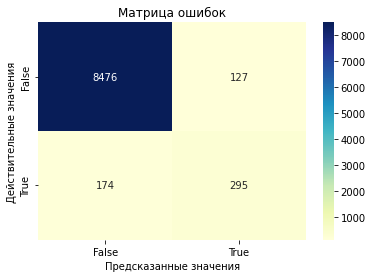

In [248]:
print_metrics(model)

Алгоритм XGBoost требует слишком много ресурсов. К тому же, предыдущие модели справились лучше. Эффективнее будет подобрать параметры для RandomForestClassifier, ведь он показал наилучший результат. 

## Настройка гиперпараметров выбранной модели

In [254]:
cv = StratifiedKFold(5, random_state=1, shuffle=True)

In [275]:
def search(X, y, model, param_name, grid):
    parameters = {param_name: grid}
    
    CV_model = GridSearchCV(estimator=model, param_grid=parameters, cv=cv, scoring="roc_auc", n_jobs=-1)
    CV_model.fit(X, y)
    means = CV_model.cv_results_["mean_test_score"]
    error = CV_model.cv_results_["std_test_score"]

    plt.figure(figsize=(15, 8))
    plt.title("Выбор параметра " + param_name)

    plt.plot(grid, means, label="mean values of score")
    plt.fill_between(grid, means - 2 * error, means + 2 * error, color="green", label="Область отклонения между ошибками")
    plt.legend(loc="upper left")
    plt.xlabel("Параметр")
    plt.ylabel("roc-auc")
    plt.grid()
    plt.show()

Подберу оптимальное значение количества деревьев в лесу алгоритма

Ограничу количество записей для обучения 1000, чтобы не тратить слишком много времени

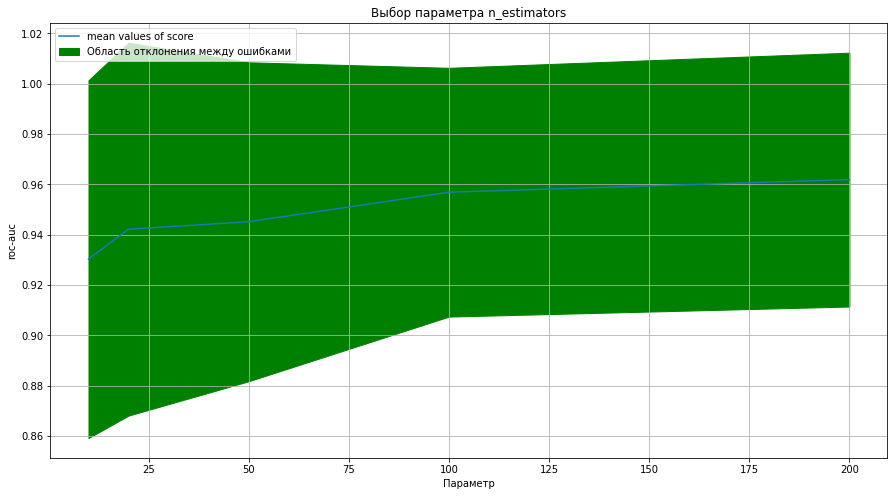

In [310]:
models = [RandomForestClassifier(random_state=1, n_jobs=-1)]
param_names = ["n_estimators"]
grids = [np.array([10, 20, 50, 100, 200], dtype="int")]

for model, param_name, grid in zip(models,
                                   param_names,
                                   grids):
    search(X_train[:1000], y_train[:1000], model, param_name, grid)

Получилось, что значение 100 наиболее оптимально

Настрою таким же образом параметр максимальной глубины "max_depth"

Чтобы не ждать слишком долго, ограничу размер тренировочных данных

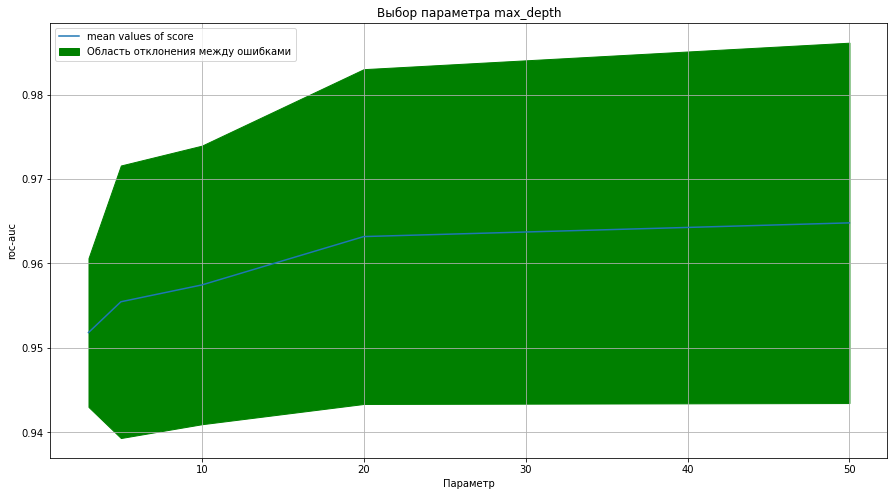

In [311]:
models = [RandomForestClassifier(n_estimators=100, random_state=1, n_jobs=-1)]
param_names = ["max_depth"]
grids = [np.array([3, 5, 10, 20, 50], dtype="int")]

for model, param_name, grid in zip(models,
                                   param_names,
                                   grids):
    search(X_train[:10000], y_train[:10000], model, param_name, grid)

Максимальной глубины 30 должно хватить

Теперь очередь параметра min_samples_leaf, отвечающего за минимальное число образцов в каждом из листов дерева алгоритма

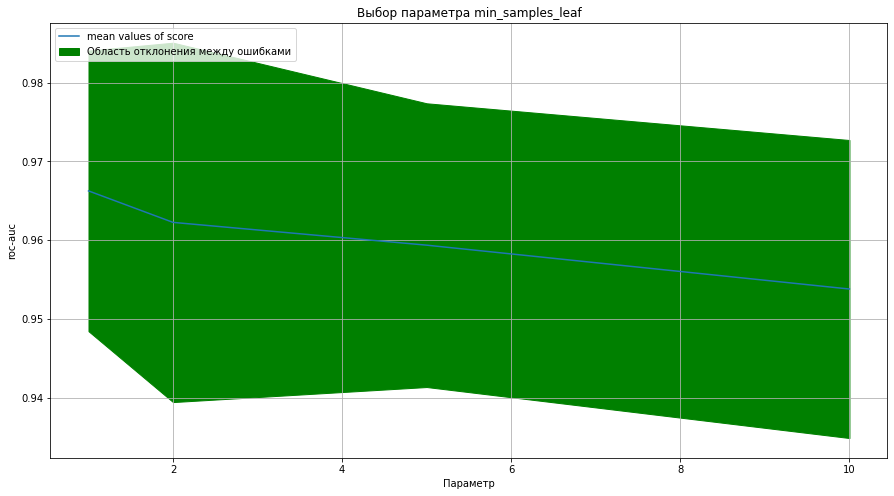

In [314]:
models = [RandomForestClassifier(n_estimators=100, max_depth=30, random_state=1, n_jobs=-1)]
param_names = ["min_samples_leaf"]
grids = [np.array([1, 2, 5, 10], dtype="int")]

for model, param_name, grid in zip(models,
                                   param_names,
                                   grids):
    search(X_train[:10000], y_train[:10000], model, param_name, grid)

Лучше оставить стандартное значение 1

Теперь осталось обучить финальную модель и проверить её метрики

In [315]:
model = RandomForestClassifier(n_estimators=100, max_depth=30, random_state=1, n_jobs=-1)
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=30, n_jobs=-1, random_state=1)

Train MSE: 0.032
Test MSE: 0.040
Train MAE: 0.032
Test MAE: 0.040
accuracy: 0.96
precision: 0.83
recall: 0.28
roc_auc_score: 0.73


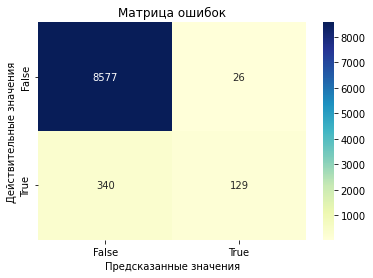

In [316]:
print_metrics(model)

Сравним метрики всех моделей:  
  
Для логистической регрессии:  
- Train MSE: 0.039
- Test MSE: 0.037
- Train MAE: 0.039
- Test MAE: 0.037
- accuracy: 0.96
- precision: 0.65
- recall: 0.63
- roc_auc_score: 0.81
  
Для случайного леса до настройки гиперпараметров:  
- Train MSE: 0.004
- Test MSE: 0.033
- Train MAE: 0.004
- Test MAE: 0.033
- accuracy: 0.97
- precision: 0.71
- recall: 0.61
- roc_auc_score: 0.97
  
Для XGBoost:  
- Train MSE: 0.019
- Test MSE: 0.033
- Train MAE: 0.019
- Test MAE: 0.033
- accuracy: 0.97
- precision: 0.70
- recall: 0.63
- roc_auc_score: 0.89
  
Для настроенного случайного леса:  
- Train MSE: 0.032
- Test MSE: 0.040
- Train MAE: 0.032
- Test MAE: 0.040
- accuracy: 0.96
- precision: 0.83
- recall: 0.28
- roc_auc_score: 0.73

Получается, что настройка алгоритма случайного леса лишь незначительно увеличила значения метрики precision, в то же время остальные показатели сильно ухудшилось. Возможно, модель переобучилась. Нужно попробовать обучить модель со 100 деревьями, без указания максимальной глубины. Если метрики станут ещё хуже, значит, модель подвержена переобучению

In [317]:
model = RandomForestClassifier(n_estimators=100, random_state=1, n_jobs=-1)
model.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=1)

In [320]:
y_test_prediction = model.predict(X_test)

Train MSE: 0.000
Test MSE: 0.035
Train MAE: 0.000
Test MAE: 0.035
accuracy: 0.97
precision: 0.68
recall: 0.62
roc_auc_score: 1.00


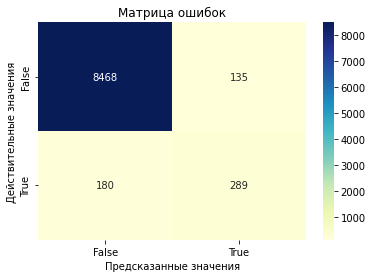

In [318]:
print_metrics(model)

In [321]:
roc_auc_score(y_test, y_test_prediction)

0.8002562452181727

Показатели мало отличаются от модели с количеством деревьев 10. Но теперь она действительно переобучилась, так как roc_auc_score на тренировочных данных стал равен единице. Решающим фактором, какую из двух моделей выбрать, станет roc_auc_score на тестовых данных

In [323]:
model = RandomForestClassifier(n_estimators=10, random_state=1, n_jobs=-1)
model.fit(X_train, y_train)
y_test_prediction = model.predict(X_test)
roc_auc_score(y_test, y_test_prediction)

0.7980459784073936

Всё-таки, результат улучшился, но разница слишком мала. Для более тщательной настройки моделей на таких больших данных необходимо много оперативной памяти, мощный процессор, а также такой алгоритм поиска гиперпараметров, при котором несколько параметров будут выбираться одновременно, чтобы исключить ухудшение качества метрик